In [55]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [56]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [57]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [58]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

Get the 1D data into a 2D matrix

In [72]:
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset
import torch
import numpy as np
from collections import Counter

shape = (16,12)

# Stap 1: Extract features and labels
X = []
y = []

for i in range(len(traindataset)):
    sample, label = traindataset[i]
    X.append(sample.numpy().flatten())  # Flatten als het 2D is
    y.append(label)

X = np.array(X)
y = np.array(y)

# Stap 2: SMOTE toepassen
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Stap 3: Zet terug naar tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32).reshape(-1, 1, *shape)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Stap 4: Maak een nieuwe dataset
traindataset = TensorDataset(X_resampled, y_resampled)

# Stap 5: Controleer nieuwe verdeling
print("Nieuwe verdeling na SMOTE:", Counter(y_resampled.numpy()))



Nieuwe verdeling na SMOTE: Counter({np.int64(0): 72471, np.int64(1): 72471, np.int64(2): 72471, np.int64(3): 72471, np.int64(4): 72471})


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

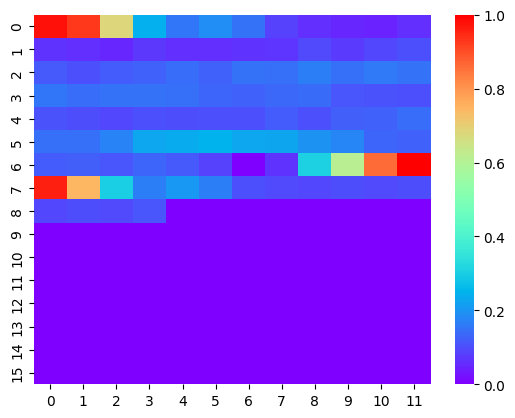

In [73]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [74]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(11323, 684)

In [75]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

`mltrainer` provides a ConvBlock, which makes it easier to stack block in the model.
It also provides an architecture inspired by AlexNet (2012) which is used as a starting point for image classification.

Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, or even vision transformers (eg see [torch docs](https://docs.pytorch.org/tutorials/beginner/vt_tutorial.html#classifying-images-with-deit) ) 
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [76]:
from mltrainer.imagemodels import CNNConfig, CNNblocks

In [77]:
config = CNNConfig(
    matrixshape=shape,
    batchsize=32,
    input_channels=1,
    hidden=32,
    kernel_size=3,
    maxpool=2,
    num_layers=2,
    num_classes=5,
)
model = CNNblocks(config)
model(x).shape

Calculated matrix size: 48
Caluclated flatten size: 1536


torch.Size([32, 5])

In [78]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [79]:
config.__dict__

{'matrixshape': (16, 12),
 'batchsize': 32,
 'input_channels': 1,
 'hidden': 32,
 'kernel_size': 3,
 'maxpool': 2,
 'num_layers': 2,
 'num_classes': 5}

Read [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) about micro and macro F1 scores.


In [81]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [82]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_v2.db")
mlflow.set_experiment("2D alexnet with sampling to 5000")

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/2', creation_time=1750241371784, experiment_id='2', last_update_time=1750241371784, lifecycle_stage='active', name='2D alexnet with sampling to 5000', tags={}>

 mlflow server \
    --backend-store-uri sqlite:///mads_exam_v2.db \
    --host 127.0.0.1 \ 
    --port 5000 \

mlflow server --backend-store-uri sqlite:///mads_exam_v2.db --host 127.0.0.1 --port 5000 

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config.__dict__)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-06-18 12:00:46.272 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart2D/20250618-120046
  0%|          | 0/10 [00:00<?, ?it/s]

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

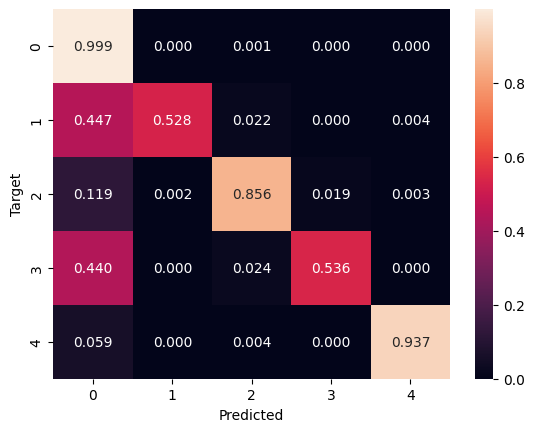

In [54]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")